In [1]:
%%capture
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Implementing Channels
=====================

Wireless propagation channels are a core concept in the physical layer modeling of communication and sensing systems.
In essence, they describe the behaviour of electromagnetic waves during their propagation between devices capable of transmitting electromagnetic radiation, receiving electromagnetic radation, or both.
Within Hermes' API, channels are addressed by the [Channel Module](../api/channel/index.rst), with each implemented channel model inheriting from a common [Channel](../api/channel/channel.Channel.rst) base class.

Adding a new channel model to the set of provided implementations is rather straightfoward:
On the most fundamental level, each channel model class is expected to provide an implementation of the abstract [_realize](../api/channel/channel.Channel.rst#hermespy.channel.channel.Channel._realize) method generating a [realization](../api/channel/channel.ChannelRealization.rst#hermespy.channel.channel.ChannelRealization).

Channel realizations represent a channels large-scale random state and are considered immutable during the simulation of a single parameter combination within a parameter sweep.

However, within simulating a single parameter combination, the channel may evolve over time and space, for example because the terminals move. For this reason, the actual channel is generated by "[sample](../api/channel/channel.ChannelRealization.rst#hermespy.channel.channel.ChannelRealization.sample)ing" a realization given the locations of a transmitting and receiving device, as well as a global time of signal propagation. 
The result is represented by a [ChannelSample](../api/channel/channel.ChannelSample.rst) over which electromagnetic signals may be propagated in between the transmitting and receiving device.

To demonstrate the API workflow, we will implement a basic channel only introducing a random phase shift to the propagated waveform, no time of flight delays or multiple antenna scenarios are considered:

In [ ]:
from __future__ import annotations
from typing import Set

import numpy as np

from hermespy.core import ChannelStateInformation, ChannelStateFormat, DeserializationProcess, InterpolationMode, SerializationProcess, SignalBlock
from hermespy.channel import Channel, ChannelRealization, ChannelSample, ChannelSampleHook, LinkState
from hermespy.channel.consistent import ConsistentUniform, ConsistentGenerator, ConsistentRealization


class PhaseShiftChannelSample(ChannelSample):

    def __init__(
        self,
        phase_shift: float,
        gain: float,
        state: LinkState,
    ) -> None:
        ChannelSample.__init__(self, state)
        self.__phase_shift = phase_shift
        self.__gain = gain
        
    @property
    def phase_shift(self) -> float:
        return self.__phase_shift
    
    @property
    def gain(self) -> float:
        return self.__gain
        
    def _propagate(
        self,
        signal: SignalBlock,
        interpolation: InterpolationMode,
     ) -> SignalBlock:
        phase_shifted_block = signal * np.exp(1j * self.__phase_shift)
        return self.__gain ** .5 * phase_shifted_block

    def state(
        self,
        num_samples: int,
        max_num_taps: int,
        interpolation_mode: InterpolationMode = InterpolationMode.NEAREST,
    ) -> ChannelStateInformation:
        state = self.__gain**.5 * np.exp(1j * self.__phase_shift) * np.ones((self.receiver_state.antennas.num_receive_antennas, self.transmitter_state.antennas.num_transmit_antennas, num_samples, 1), dtype=complex)
        return ChannelStateInformation(ChannelStateFormat.IMPULSE_RESPONSE, state)


class PhaseShiftChannelRealization(ChannelRealization[PhaseShiftChannelSample]):

    def __init__(
        self,
        rng: ConsistentRealization,
        phase_shift_variable: ConsistentUniform,
        sample_hooks: Set[ChannelSampleHook[PhaseShiftChannelSample]] | None = None,
        gain: float = 1.0,
    ) -> None:
        ChannelRealization.__init__(self, sample_hooks, gain)
        self.__rng = rng
        self.__phase_shift_variable = phase_shift_variable
    
    def _sample(self, state: LinkState) -> PhaseShiftChannelSample:
        consistent_sample = self.__rng.sample(state.transmitter.position, state.receiver.position)
        phase_shift = 2 * np.pi * self.__phase_shift_variable.sample(consistent_sample)
        return PhaseShiftChannelSample(phase_shift, self.gain, state)
        
    def _reciprocal_sample(self, sample: PhaseShiftChannelSample, state: LinkState) -> PhaseShiftChannelSample:
        return PhaseShiftChannelSample(sample.phase_shift, sample.gain, state)

    def serialize(self, process: SerializationProcess) -> None:
        process.serialize_object(self.__rng, "rng")
        process.serialize_object(self.__phase_shift_variable, "phase_shift_variable")
        ChannelRealization.serialize(self, process)

    @classmethod
    def _DeserializeParameters(cls, process: DeserializationProcess) -> dict[str, object]:
        parameters = ChannelRealization._DeserializeParameters(process)
        parameters["rng"] = process.deserialize_object("rng")
        parameters["phase_shift_variable"] = process.deserialize_object("phase_shift_variable")
        return parameters

    @classmethod
    def Deserialize(cls, process: DeserializationProcess) -> PhaseShiftChannelRealization:
        return cls(**cls._DeserializeParameters(process))


class PhaseShiftChannel(Channel[PhaseShiftChannelRealization, PhaseShiftChannelSample]):
    
    def __init__(self, decorrelation_distance: float) -> None:
        Channel.__init__(self)
        self.__decorrelation_distance = decorrelation_distance
        self.__rng = ConsistentGenerator(self)
        self.__phase_shift_variable = self.__rng.uniform()
    
    def _realize(self) -> PhaseShiftChannelRealization:
        return PhaseShiftChannelRealization(
            self.__rng.realize(self.__decorrelation_distance),
            self.__phase_shift_variable,
            self.sample_hooks,
            self.gain,
        )

    def serialize(self, process: SerializationProcess) -> None:
        process.serialize_floating(self.__decorrelation_distance, "decorrelation_distance")
        Channel.serialize(self, process)
        
    @classmethod
    def _DeserializeParameters(cls, process: DeserializationProcess) -> dict[str, object]:
        parameters = Channel._DeserializeParameters(process)
        parameters["decorrelation_distance"] = process.deserialize_floating("decorrelation_distance")
        return parameters

    @classmethod
    def Deserialize(cls, process: DeserializationProcess) -> PhaseShiftChannel:
        return cls(**cls._DeserializeParameters(process))

We can now plug the newly generated channel model into a simulation scenario evaluating an [OFDM waveform](../api/modem/waveforms.orthogonal.ofdm.OFDMWaveform.rst) with access to ideal channel state information, equalizing the channel by [zero forcing](../api/modem/waveform.ZeroForcingChannelEqualization.rst):

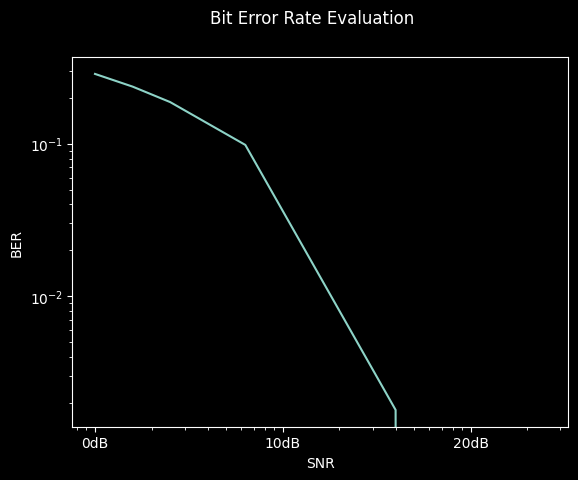

In [3]:
import matplotlib.pyplot as plt

from hermespy.core import dB, ConsoleMode
from hermespy.simulation import Simulation, OFDMIdealChannelEstimation
from hermespy.modem import BitErrorEvaluator, DuplexModem, ElementType, GridElement, GridResource, SymbolSection, OFDMWaveform, ZeroForcingChannelEqualization


# Create a new Monte Carlo simulation
simulation = Simulation(console_mode=ConsoleMode.SILENT)

# Add a single device, operated by a communication modem
device = simulation.new_device()
operator = DuplexModem()
device.add_dsp(operator)


# Configure an OFDM waveform with a frame consisting of a single symbol section
operator.waveform = OFDMWaveform(grid_resources=[GridResource(elements=[GridElement(ElementType.DATA, 1024)])],
                                 grid_structure=[SymbolSection(pattern=[0])])

# Add channel equalization routine
operator.waveform.channel_equalization = ZeroForcingChannelEqualization()

# Configure our newly implemented channel model
channel = PhaseShiftChannel(decorrelation_distance=10)
simulation.scenario.set_channel(device, device, channel)
operator.waveform.channel_estimation = OFDMIdealChannelEstimation(channel, device, device)

# Configure a parameter sweep over the receiver SNR, effectively simulating an AWGN channel
simulation.new_dimension('noise_level', dB(0, 2, 4, 8, 16, 24), device)

# Evaluate the BER
simulation.add_evaluator(BitErrorEvaluator(operator, operator))

# Configure the number of Monte Carlo samples per SNR point
simulation.num_samples = 1000

# Run the simulation and plot the results
result = simulation.run()
result.plot()
plt.show()

The channel's effect on the communication performance can be higlighted by disabling the zero-forcing channel equalization routine for the configured OFDM waveform.

In this case, the communication bit error rate should roughly approximate $\tfrac{1}{2}$, indicating that no information is exchanged and the bits are essentially random at the receiver.

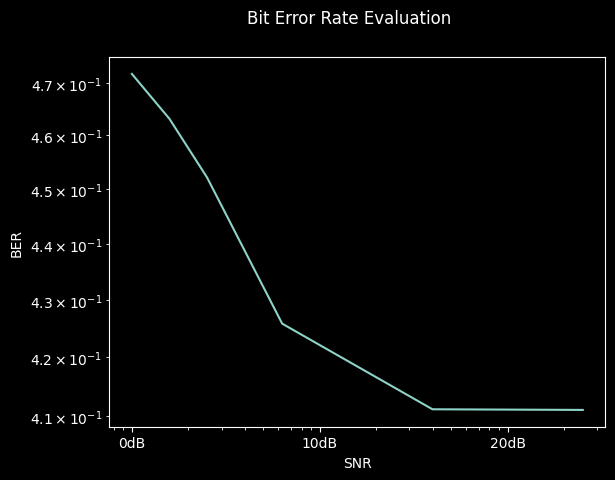

In [4]:
from hermespy.modem import ChannelEqualization

# Disable channel equalization by replacing the ZF routine with the default stub
operator.waveform.channel_equalization = ChannelEqualization()

# Run the simulation and plot the results
result = simulation.run()
result.plot()
plt.show()